In [ ]:
import numpy as np
import tvm
from tvm import te
from matplotlib import pyplot as plt

[00:22:10] /home/aditya/Downloads/tvm/src/target/llvm/llvm_instance.cc:226: Error: Using LLVM 19.1.3 with `-mcpu=apple-latest` is not valid in `-mtriple=arm64-apple-macos`, using default `-mcpu=generic`
[00:22:10] /home/aditya/Downloads/tvm/src/target/llvm/llvm_instance.cc:226: Error: Using LLVM 19.1.3 with `-mcpu=apple-latest` is not valid in `-mtriple=arm64-apple-macos`, using default `-mcpu=generic`
[00:22:10] /home/aditya/Downloads/tvm/src/target/llvm/llvm_instance.cc:226: Error: Using LLVM 19.1.3 with `-mcpu=apple-latest` is not valid in `-mtriple=arm64-apple-macos`, using default `-mcpu=generic`


In [ ]:
input_channels = 64
output_channels = 64
kernel_size = 3
input_height = 56
input_width = 56
padding = (1,1)

output_height = (input_height + 2*padding[0] - kernel_size + 1)
output_width = (input_width + 2*padding[1] - kernel_size + 1)

# We define the input in H, W, C (height, width, channels) layout
input_shape = (input_height+2*padding[0], input_width+2*padding[1], input_channels)
# We define the kernel weights in H, W, I, O (kernel height, kernel width, input
# channel, output channel) layout
weight_shape = (kernel_size, kernel_size, input_channels, output_channels)
# We define the output in H, W, C (height, width, channels) layout
output_shape = (output_height, output_width, output_channels)
     

In [ ]:
input_placeholder = tvm.te.placeholder(input_shape,name= 'data')
weight_placeholder = tvm.te.placeholder(weight_shape, name = "weight")

rc = tvm.te.reduce_axis((0,input_channels), name = 'rc')
ry = tvm.te.reduce_axis((0,kernel_size), name = 'ry')
rx = tvm.te.reduce_axis((0,kernel_size), name = 'rx')

comp = te.compute(
    (output_height, output_width, output_channels),
    lambda output_y, output_x, output_channel:
    te.sum(
        input_placeholder[output_y + ry, output_x + rx, rc] *
        weight_placeholder[ry, rx, rc, output_channel],
        axis=[ry, rx, rc]
    ),
    name="conv2d"
)


## Default Schedule without any optimizations

In [16]:

# Create the new TensorIR schedule
te_schedule = te.create_schedule(comp.op)

# Lower TE schedule into TIR (creates a PrimFunc/IRModule)
prim_func = tvm.lower(te_schedule, [input_placeholder, weight_placeholder, comp], name="main")

# Now create a TensorIR schedule
tir_schedule = tvm.tir.Schedule(prim_func)

# Print the lowered TIR
print(tir_schedule.mod.script())


# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(data: T.Buffer((58, 58, 64), "float32"), weight: T.Buffer((3, 3, 64, 64), "float32"), conv2d: T.Buffer((56, 56, 64), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        for output_y, output_x, output_channel in T.grid(56, 56, 64):
            conv2d_1 = T.Buffer((200704,), data=conv2d.data)
            conv2d_1[output_y * 3584 + output_x * 64 + output_channel] = T.float32(0.0)
            for ry, rx, rc in T.grid(3, 3, 64):
                cse_var_2: T.int32 = output_x * 64
                cse_var_1: T.int32 = output_y * 3584 + cse_var_2 + output_channel
                data_1 = T.Buffer((215296,), data=data.data)
                weight_1 = T.Buffer((36864,), data=weight.data)
                conv2d_1[cse_var_1] = conv2d_1[cse_var_1] + data_1[output_y * 3712 + ry * 3712 + cse_var_2 + rx * 64 + rc] * wei

In [28]:
default_func = tvm.build(te_schedule, [input_placeholder, weight_placeholder, comp], target='llvm -mcpu=core-avx2', name='conv')
timer = default_func.time_evaluator(default_func.entry_name, tvm.cpu(0), min_repeat_ms=100)

# data arrays for inputs and outputs to the function
data = np.random.random(input_shape).astype('float32')
weight = np.random.random(weight_shape).astype('float32')
data_tvm = tvm.nd.array(data)
weight_tvm = tvm.nd.array(weight)
output_tvm = tvm.nd.array(np.empty(output_shape).astype('float32'))
# time the execution of the function
res_default = timer(data_tvm, weight_tvm, output_tvm)
print("Conv2D with default schedule finished in:", res_default.mean, "seconds")
     

Conv2D with default schedule finished in: 0.003269360151515152 seconds


## Reordered Scedule with Convolution Optimised

In [22]:
yo, xo, co = comp.op.axis
ry, rx, rc = te_schedule[comp].op.reduce_axis
te_schedule[comp].reorder(rx, ry, yo, xo, rc, co)

conv_prim_func = tvm.lower(te_schedule, [input_placeholder, weight_placeholder, comp], name="conv_sched")

conv_tir_sched = tvm.tir.Schedule(conv_prim_func)

print(conv_tir_sched.mod.script())


# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def conv_sched(data: T.Buffer((58, 58, 64), "float32"), weight: T.Buffer((3, 3, 64, 64), "float32"), conv2d: T.Buffer((56, 56, 64), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        conv2d_1 = T.Buffer((200704,), data=conv2d.data)
        for output_y_init, output_x_init in T.grid(56, 56):
            conv2d_1[output_y_init * 3584 + output_x_init * 64:output_y_init * 3584 + output_x_init * 64 + 64] = T.Broadcast(T.float32(0.0), 64)
        for rx, ry, output_y, output_x, rc in T.grid(3, 3, 56, 56, 64):
            cse_var_2: T.int32 = output_x * 64
            cse_var_1: T.int32 = output_y * 3584 + cse_var_2
            data_1 = T.Buffer((215296,), data=data.data)
            weight_1 = T.Buffer((36864,), data=weight.data)
            conv2d_1[cse_var_1:cse_var_1 + 64] = conv2d_1[cse_var_1:cse_var_1 + 64] + T.

In [26]:
reordered_func = tvm.build(te_schedule, [input_placeholder, weight_placeholder, comp], target='llvm -mcpu=core-avx2', name='conv')
timer = reordered_func.time_evaluator(reordered_func.entry_name, tvm.cpu(0), min_repeat_ms=100)
res_reorder = timer(data_tvm, weight_tvm, output_tvm)
print("Conv2D with reordered schedule finished in:", res_reorder.mean, "seconds")

Conv2D with reordered schedule finished in: 0.00349604790625 seconds


## Vectorized and Reordered Schedule

In [29]:
te_schedule[comp].vectorize(co)

vectorize_conv_prim_func = tvm.lower(te_schedule, [input_placeholder, weight_placeholder, comp], name="conv_sched_vectorize")

reordered_parallel_func = tvm.build(te_schedule, [input_placeholder, weight_placeholder, comp], target='llvm -mcpu=core-avx2', name='conv')
timer = reordered_parallel_func.time_evaluator(reordered_parallel_func.entry_name, tvm.cpu(0), min_repeat_ms=100)
res_vectorize = timer(data_tvm, weight_tvm, output_tvm)
print("Conv2D with reordered and vectorized schedule finished in:", res_vectorize.mean, "seconds")

Conv2D with reordered and vectorized schedule finished in: 0.0031304327500000003 seconds


([<matplotlib.axis.YTick at 0x7ad40b3b7710>,
 [Text(0, 0, 'default'),
  Text(0, 1, '+reorder'),
  Text(0, 2, '+reorder,vectorize')])

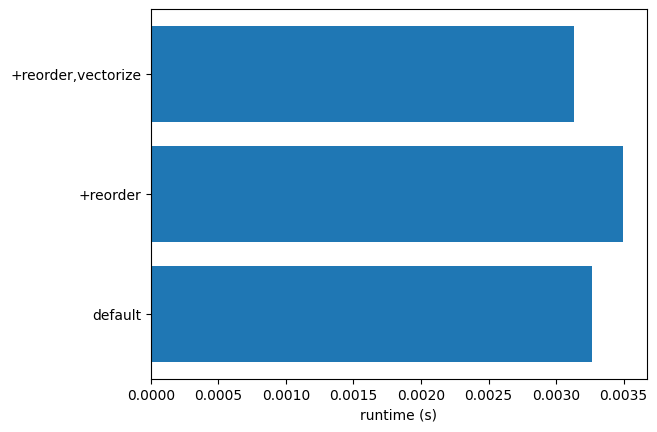

In [30]:
res = [res_default.mean, res_reorder.mean, res_vectorize.mean]
y_pos = np.arange(len(res))
plt.xlabel('runtime (s)')
labels = ['default', '+reorder', '+reorder,vectorize']

plt.barh(y_pos, res)
plt.yticks(y_pos, labels)